In [1]:
%load_ext autoreload

In [2]:
%autoreload
from npyx import *

npyx version 2.6.1 imported.


# Load Spike Data

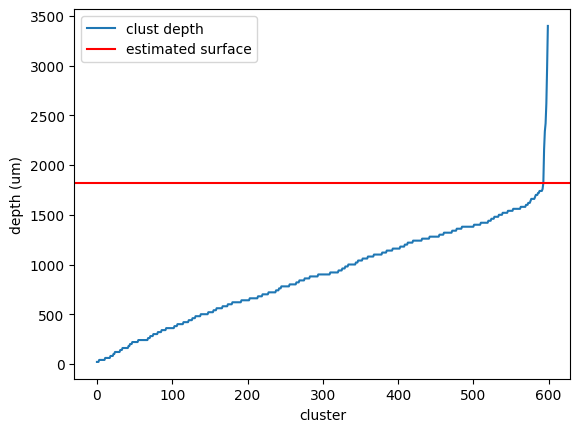

In [5]:
#dp = r'D:\spikes\CA011\2022-10-13_12-51-32\Record Node 107\experiment1\recording1\continuous\Neuropix-PXI-100.ProbeA-AP'
#dp = r'D:\spikes\CA011\2022-10-13_12-51-32_old\Record Node 107\experiment1\recording1'
#dp = r'D:\spikes\CA011\2022-10-14_12-28-53\Record Node 107\experiment1\recording1'
dp = r'D:\spikes\CA011\2022-10-13_12-51-32\Record Node 107\experiment1\recording1'
# test_npyx(dp)
clust = get_units(dp)
clust_info = get_units_info(dp)

# approximate brain surface by looking at where the units are
good_unit_depth = clust_info[clust_info.KSLabel=='good'].depth
surface_depth = np.sort(good_unit_depth)[np.argwhere(np.diff(good_unit_depth)>100)[0][0]]
plt.plot(np.sort(good_unit_depth),label='clust depth')
plt.axhline(surface_depth,color='r',label='estimated surface')
plt.xlabel('cluster')
plt.ylabel('depth (um)')
plt.legend()

# adjust depth to be relative to brain surface
clust_info['adj_depth'] = -(clust_info.depth - surface_depth)

In [52]:
# load spikes
good = (clust_info.KSLabel == 'good') & ()
good_cells = clust_info.cluster_id[good]
good_cells_info = clust_info.loc[good]
good_cells_info = good_cells_info.reset_index()
spks, spike_clusters, spike_samples = load_spikes(dp, good_cells)
fs = 30e3
spks = [s/fs/60 for s in spks]

In [53]:
%autoreload
from npyx import *
units = good_cells_info.cluster_id
# raw data are whitened, high-pass filtered and median-subtracted by default - parameters are explicit below
plot_raw_units(dp, times=[902.05,902.15], units = units, channels=range(0,150),
               lw=1, offset=300, figsize=(6,12), Nchan_plot=10,
               med_sub=1, whiten=1, hpfilt=1)

AssertionError: WARNING no .ap/lf.meta (spikeGLX) or .oebin (OpenEphys) file found at D:\spikes\CA011\2022-10-13_12-51-32\Record Node 107\experiment1\recording1\continuous\Neuropix-PXI-100.ProbeA-AP.

In [30]:
clust_info

,cluster_id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh
0,0,3442.0,100.0,good,128.304565,2,40.0,6.011463,11055,0,NaN
1,1,1631.4,100.0,mua,64.581619,3,40.0,0.684072,1258,0,NaN
2,2,1858.8,100.0,good,102.198624,1,20.0,5.418745,9965,0,NaN
3,3,1582.0,100.0,mua,92.493561,2,40.0,2.077775,3821,0,NaN
4,4,1491.6,100.0,good,76.673874,0,20.0,0.294184,541,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
567,655,3255.3,100.0,good,45.866852,367,3700.0,0.067972,125,0,NaN
568,656,1301.6,100.0,mua,52.271690,370,3720.0,0.780321,1435,0,NaN
569,657,1757.8,100.0,mua,46.646465,374,3760.0,1.077767,1982,0,NaN
570,658,3449.1,100.0,mua,52.937153,378,3800.0,0.536709,987,0,NaN


In [ ]:
# load the messages
start_time = 168801936 # from sync_messages.txt
ts = np.load(f'{dp}/events/MessageCenter/sample_numbers.npy') - start_time # offset by recording start time
txt = np.load(f'{dp}/events/MessageCenter/text.npy')
txt = [t.decode('UTF-8') for t in txt]
u,i = np.unique(ts,return_index=True)
ts = ts[i] / fs / 60 # convert to minutes
txt = [txt[j] for j in i]

In [ ]:
len(spks)

145

# Plot and analyze ISI dist

In [ ]:
# select only the good units
if (2+2) == 5:
    good_clusters = [i for i in spike_clusters if i in good_cells]
    good_samples = [spike_samples[i] for i,c in enumerate(spike_clusters) if c in good_cells]
    good_depths = [good_cells_info.loc[[i]].adj_depth for i in spike_clusters if i in good_cells] # this takes forever
    fig,ax = plt.subplots(1,1,figsize=(10,5))
    ax.scatter(good_samples,good_clusters,1,alpha=0.05)
    plt.gca().invert_yaxis()

0) starting robot wheel tests
1) t1
2) t2
3) t3 - 60s
4) t4 - on-off 1hz 30 secs
5) t5 - moved closer ran 30 s
6) t6 - moved closer ran 60 s
7) motor tests
8) t1 - trigger puff for 30 seconds
9) t2 - moved closer and trigger puff 30 sec
10) (didnt send messages when connected)
11) ran motor low speed, close to mouse 60 s
12) ran motor low speed, close to mouse 60 s
13) baseline 60s


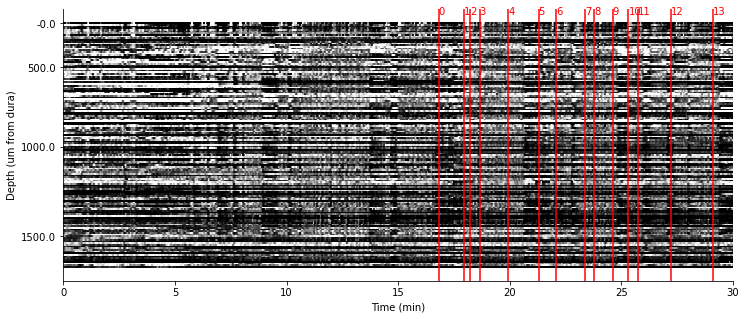

In [ ]:
# sort cells by depth
Y = good_cells_info.adj_depth
X = spks
spks_sort = [x for _, x in sorted(zip(Y, X), key=lambda pair: pair[0])]
fig,ax = plt.subplots(1,1,figsize=(12,5))
_ = ax.eventplot(spks_sort,colors='k',linewidths=0.1)
plt.axis('tight')
tickl = np.unique(np.sort(good_cells_info.adj_depth)[(np.sort(good_cells_info.adj_depth) % 500) == 0])
ticks = [np.argmax(np.sort(good_cells_info.adj_depth) >= i) for i in tickl]
ax.yaxis.set_ticks(ticks)
ax.yaxis.set_ticklabels(tickl)
for i,t in enumerate(ts):
    ax.axvline(t,color='r')
    ax.text(t,-5,str(i),color='r')
    print(f'{i}) {txt[i]}')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Depth (um from dura)')
ax.set_xlim([0,30])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().invert_yaxis()
#fig.savefig('spike_raster.pdf')

WilcoxonResult(statistic=3318.0, pvalue=9.729993047975963e-05)


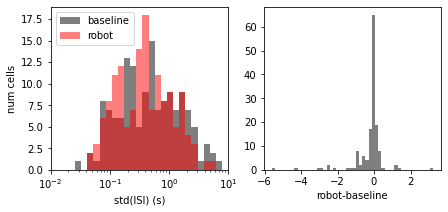

In [ ]:
# for each cell, compute std of ISIs before and after 15 minutes
pre_std = []
post_std = []
for u in spks:
    pre_std.append(np.nanstd(np.diff(u[u<15]) * 60))
    post_std.append(np.nanstd(np.diff(u[u>15]) * 60))
pre_std = np.array(pre_std)
post_std = np.array(post_std)
mn,mx = 0.01,10
bins = np.logspace(np.log10(mn),np.log10(mx),30)
fig,ax = plt.subplots(1,2,figsize=(7,3))
ax[0].hist(pre_std,bins,color='k',alpha=0.5,label='baseline')
ax[0].hist(post_std,bins,color='r',alpha=0.5,label='robot')
ax[0].set_xscale('log')
ax[0].set_xlim([mn,mx])
ax[0].set_xlabel('std(ISI) (s)')
ax[0].set_ylabel('num cells')
ax[0].legend()

ax[1].hist(post_std-pre_std,50,color='k',alpha=0.5)
ax[1].set_xlabel('robot-baseline')

from scipy.stats import wilcoxon
print(wilcoxon(post_std,pre_std))

# Synchronize data streams
First load timestamps for relevant files

In [ ]:
ts = {'ap': np.load(os.path.join(dp,'continuous','Neuropix-PXI-100.ProbeA-AP','timestamps.npy')),\
      'lfp': np.load(os.path.join(dp,'continuous','Neuropix-PXI-100.ProbeA-LFP','timestamps.npy')),\
      'nidaq': np.load(os.path.join(dp,'continuous','NI-DAQmx-103.PXI-6133','timestamps.npy'))}

Load raw binary data

In [ ]:
def load_binary_chunk(dp, times, channels=np.arange(384), filt_key='lowpass', scale=True, verbose=False):
    dp = Path(dp)
    meta = read_metadata(dp)
    fname = Path(dp)/meta['lowpass']['binary_relative_path'][2:]
    
    fs = meta[filt_key]['sampling_rate']
    Nchans=meta[filt_key]['n_channels_binaryfile']
    bytes_per_sample=2
    
    assert len(times)==2
    assert times[0]>=0
    assert times[1]<meta['recording_length_seconds']
    
    # Format inputs
    ignore_ks_chanfilt = True
    channels=assert_chan_in_dataset(dp, channels, ignore_ks_chanfilt)
    t1, t2 = int(np.round(times[0]*fs)), int(np.round(times[1]*fs))
    
    vmem=dict(psutil.virtual_memory()._asdict())
    chunkSize = int(fs*Nchans*bytes_per_sample*(times[1]-times[0]))
    if verbose:
        print('Used RAM: {0:.1f}% ({1:.2f}GB total).'.format(vmem['used']*100/vmem['total'], vmem['total']/1024/1024/1024))
        print('Chunk size:{0:.3f}MB. Available RAM: {1:.3f}MB.'.format(chunkSize/1024/1024, vmem['available']/1024/1024))
    if chunkSize>0.9*vmem['available']:
        print('WARNING you are trying to load {0:.3f}MB into RAM but have only {1:.3f}MB available.\
              Pick less channels or a smaller time chunk.'.format(chunkSize/1024/1024, vmem['available']/1024/1024))
        return
    
    # Get chunk from binary file
    with open(fname, 'rb') as f_src:
        # each sample for each channel is encoded on 16 bits = 2 bytes: samples*Nchannels*2.
        byte1 = int(t1*Nchans*bytes_per_sample)
        byte2 = int(t2*Nchans*bytes_per_sample)
        bytesRange = byte2-byte1

        f_src.seek(byte1)

        bData = f_src.read(bytesRange)
        
    # Decode binary data
    # channels on axis 0, time on axis 1
    assert len(bData)%2==0
    rc = np.frombuffer(bData, dtype=np.int16) # 16bits decoding
    rc = rc.reshape((int(t2-t1), Nchans)).T
    rc = rc[:-1,:] # remove sync channel
    
    # Scale data
    if scale:
        rc = rc * meta['bit_uV_conv_factor'] # convert into uV
    
    return rc

In [ ]:
meta = read_metadata(dp)
fs = metadata(dp)['lowpass']['sampling_rate']
dat = load_binary_chunk(dp,[0,30*60],filt_key='lowpass')

WARNING you are trying to load 3295.898MB into RAM but have only 279.250MB available.              Pick less channels or a smaller time chunk.


75000

In [ ]:
# mdn = np.vstack([np.median(dat[i,:]) for i in range(dat.shape[0])])
dat = dat - np.median(dat,axis=1)[:,np.newaxis]

NameError: name 'dat' is not defined

In [ ]:
offset = 100
fs = 2500
w = int(np.round(fs*0.5))
start = int(np.round(fs*15*60))
rng = range(start,start+w)
plt_dat = dat[:,rng]
plt_offsets = np.arange(0, plt_dat.shape[0]*offset, offset)
plt_dat+=plt_offsets[:,np.newaxis]

fig,ax = plt.subplots(1,1,figsize=(10,20))
_ = plt.plot(plt_dat.T)

IndexError: index 2250000 is out of bounds for axis 1 with size 750000

In [ ]:
get_meta

NameError: name 'get_meta' is not defined

In [ ]:
from sys import getsizeof
getsizeof(dat)

16